In [2]:
import os
input_dir = "images"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(".jpg")]
)
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith('.png') and not fname.startswith('.')]
)

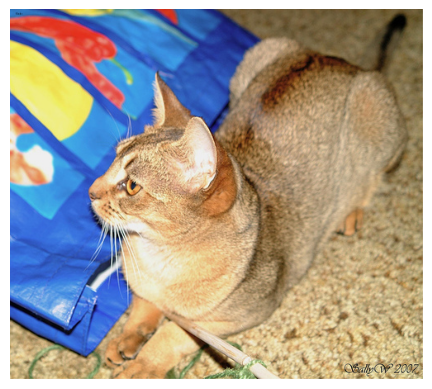

In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis('off')
plt.imshow(load_img(input_img_paths[9]))

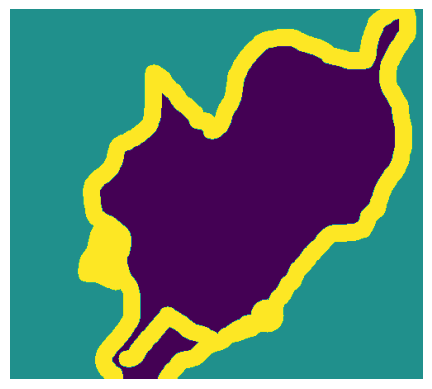

In [4]:
def display_target(target_array):
    normalized_array = (target_array.astype('uint8') - 1) * 127
    plt.axis('off')
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode='grayscale'))
display_target(img)

In [14]:
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(load_img(path, target_size=img_size, color_mode='grayscale'))
    img = img.astype('uint8') - 1
    return img

input_imgs = np.zeros((num_imgs, ) + img_size + (3, ), dtype='float32')
targets = np.zeros((num_imgs, ) + img_size + (1, ), dtype='uint8')
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [17]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    # 调整输入尺寸到[0, 1]区间
    x = layers.Rescaling(1./255)(inputs)
    
    # 压缩：进行3次两倍下采样，目的是将图像编码较小的特征图
    # strides步幅为2：图像分割关注信息的空间位置，需要生成每个像素的目标掩码作为模型输出
    # 如果模型关注特征的位置，往往使用步幅而不是最大汇聚
    x = layers.Conv2D(64, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(128, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(256, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)

    # 逆变换，对特征图进行上采样(upsample)
    x = layers.Conv2DTranspose(256, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(256, 3, activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same', strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)
    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()
    

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [18]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy')
callbacks = [
    keras.callbacks.ModelCheckpoint('oxford_segmentation.keras', save_best_only=True)
]
history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/50
100/100 [==============================] - 34s 240ms/step - loss: 1.0037 - val_loss: 0.9192
Epoch 2/50
100/100 [==============================] - 18s 178ms/step - loss: 0.9135 - val_loss: 0.8534
Epoch 3/50
100/100 [==============================] - 18s 177ms/step - loss: 0.8207 - val_loss: 0.7802
Epoch 4/50
100/100 [==============================] - 18s 176ms/step - loss: 0.7850 - val_loss: 0.7286
Epoch 5/50
100/100 [==============================] - 17s 175ms/step - loss: 0.7595 - val_loss: 0.8445
Epoch 6/50
100/100 [==============================] - 17s 174ms/step - loss: 0.7133 - val_loss: 0.6444
Epoch 7/50
100/100 [==============================] - 17s 174ms/step - loss: 0.6742 - val_loss: 0.6081
Epoch 8/50
100/100 [==============================] - 17s 174ms/step - loss: 0.6370 - val_loss: 0.6191
Epoch 9/50
100/100 [==============================] - 17s 175ms/step - loss: 0.6221 - val_loss: 0.7555
Epoch 10/50
100/100 [==============================] - 17s 175ms/step - l

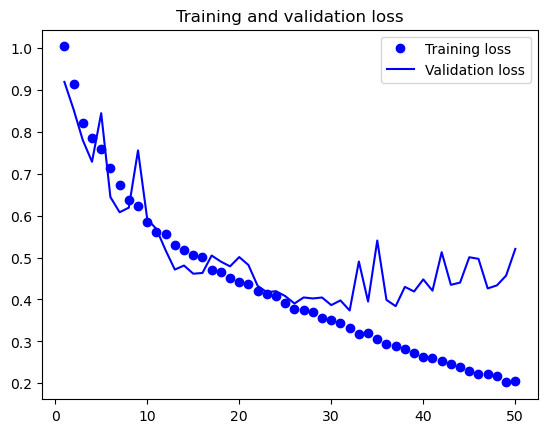

In [20]:
epochs = range(1, len(history.history['loss']) + 1)
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(epochs, loss, 'bo', label="Training loss")
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

1/1 [==============================] - 0s 90ms/step


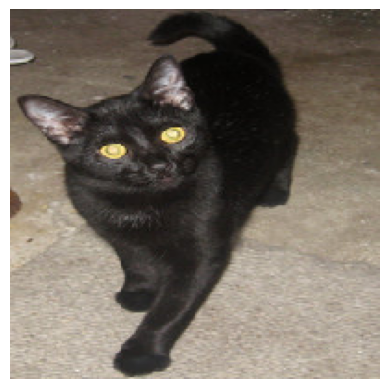

In [22]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model('oxford_segmentation.keras')

i = 4
test_image = val_input_imgs[i]
plt.axis('off')
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

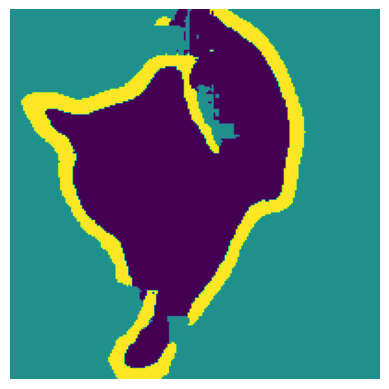

In [24]:
def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis('off')
    plt.imshow(mask)
    
display_mask(mask)

## 残差连接

In [8]:
# 滤波器发生变化时的残差块
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
residual = x
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
residual = layers.Conv2D(64, 1)(residual)
x = layers.add([x, residual])

In [9]:
# 目标层包含最大汇聚层的残差块
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
residual = x
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, padding='same')(x)
residual = layers.Conv2D(64, 1, strides=2)(residual)
x = layers.add([x, residual])

In [12]:
# 示例
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

# 实现带有残差连接的卷积层块
def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding='same')(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x

x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_2 (Rescaling)        (None, 32, 32, 3)    0           ['input_11[0][0]']               
                                                                                                  
 conv2d_26 (Conv2D)             (None, 32, 32, 32)   896         ['rescaling_2[0][0]']            
                                                                                                  
 conv2d_27 (Conv2D)             (None, 32, 32, 32)   9248        ['conv2d_26[0][0]']              
                                                                                              

In [16]:
inputs = keras.Input(shape=(180, 180, 3))
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same', use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same', use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = layers.Conv2D(size, 1, strides=2, padding='same', use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)


In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_3 (Sequential)      (None, 180, 180, 3)  0           ['input_15[0][0]']               
                                                                                                  
 rescaling_6 (Rescaling)        (None, 180, 180, 3)  0           ['sequential_3[0][0]']           
                                                                                                  
 conv2d_48 (Conv2D)             (None, 176, 176, 32  2400        ['rescaling_6[0][0]']      

## 可解释性

In [18]:
from tensorflow import keras
model = keras.models.load_model('convnet_from_scratch_with_augmentation.keras')
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [19]:
from tensorflow import keras
import numpy as np

img_path = keras.utils.get_file(
    fname='cat.jpg',
    origin='https://img-datasets.s3.amazonaws.com/cat.jpg'
)

# 打开图像并调整尺寸
def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

80329/80329 [==============================] - 0s 2us/step


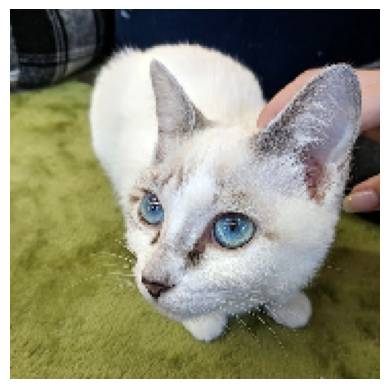

In [20]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype('uint8'))
plt.show()

In [23]:
# 实例化一个返回各层激活值的模型
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)
activation_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [24]:
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 2s 2s/step


In [27]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


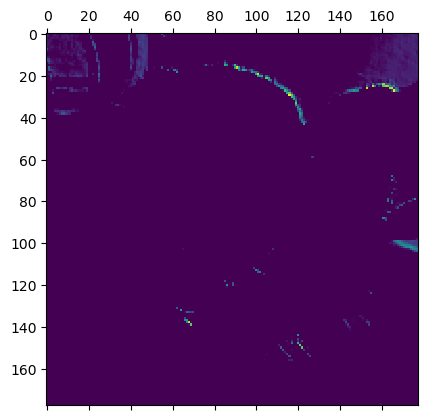

In [32]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')

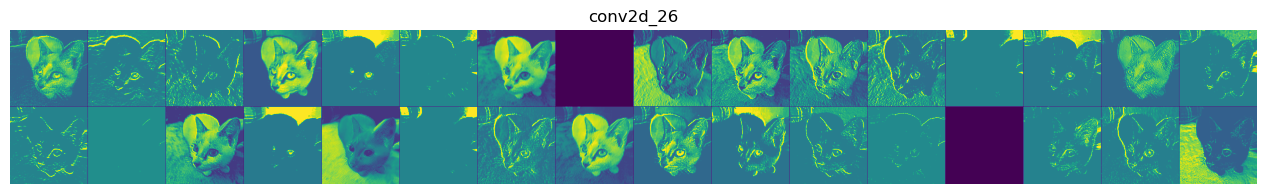

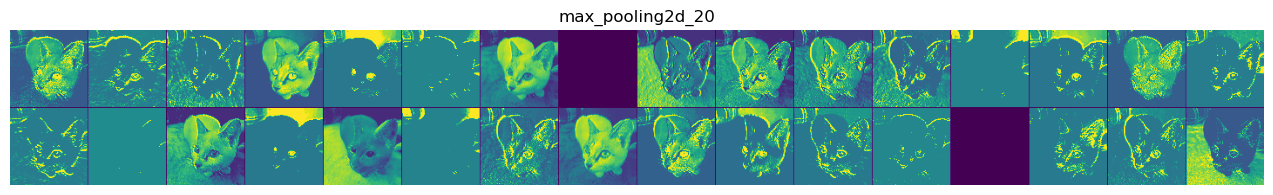

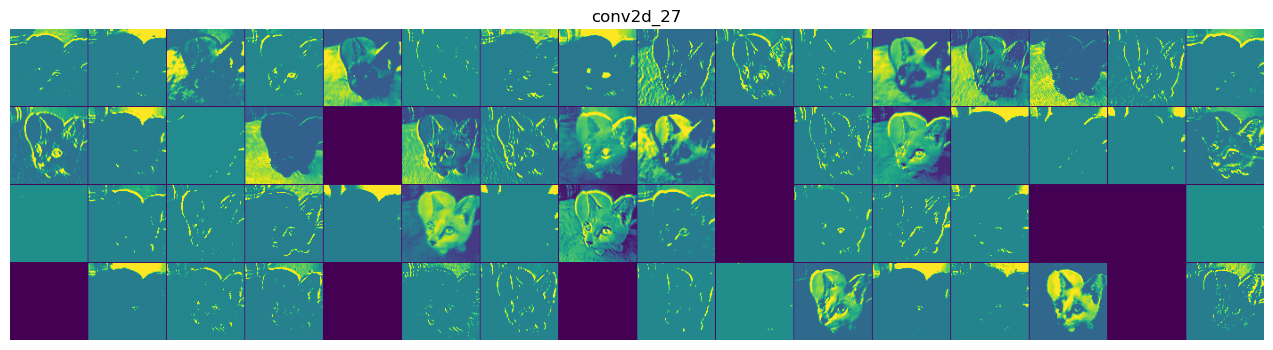

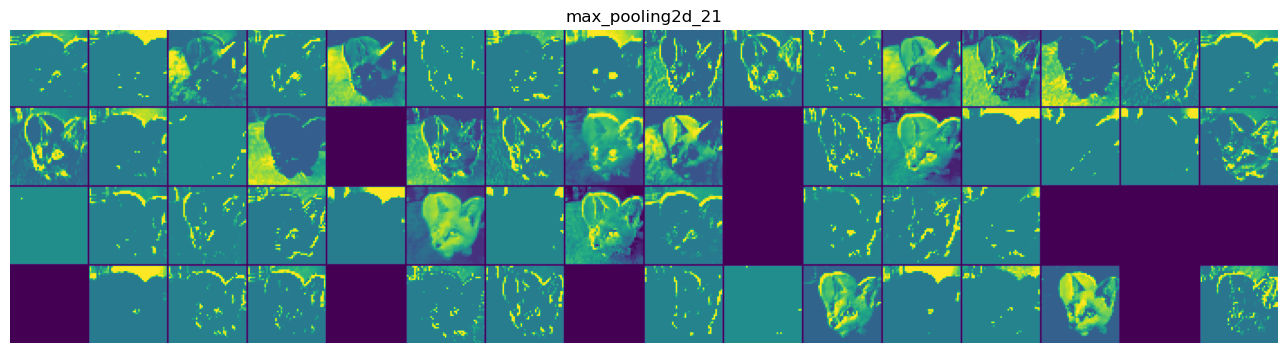

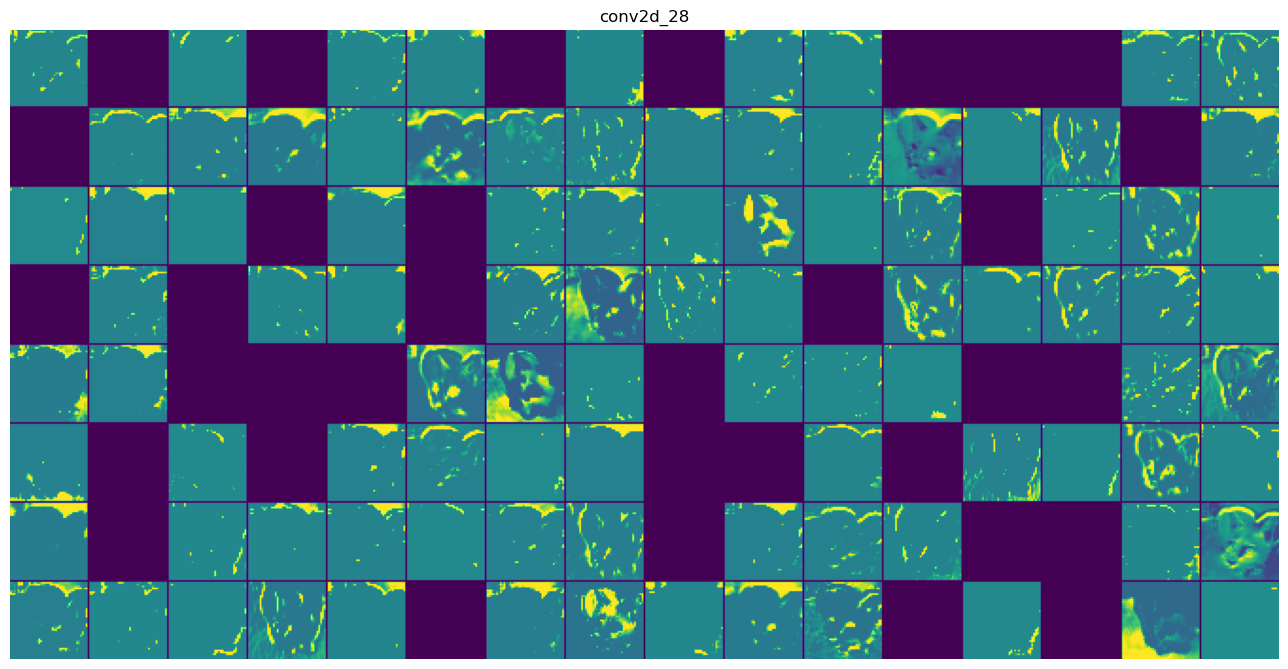

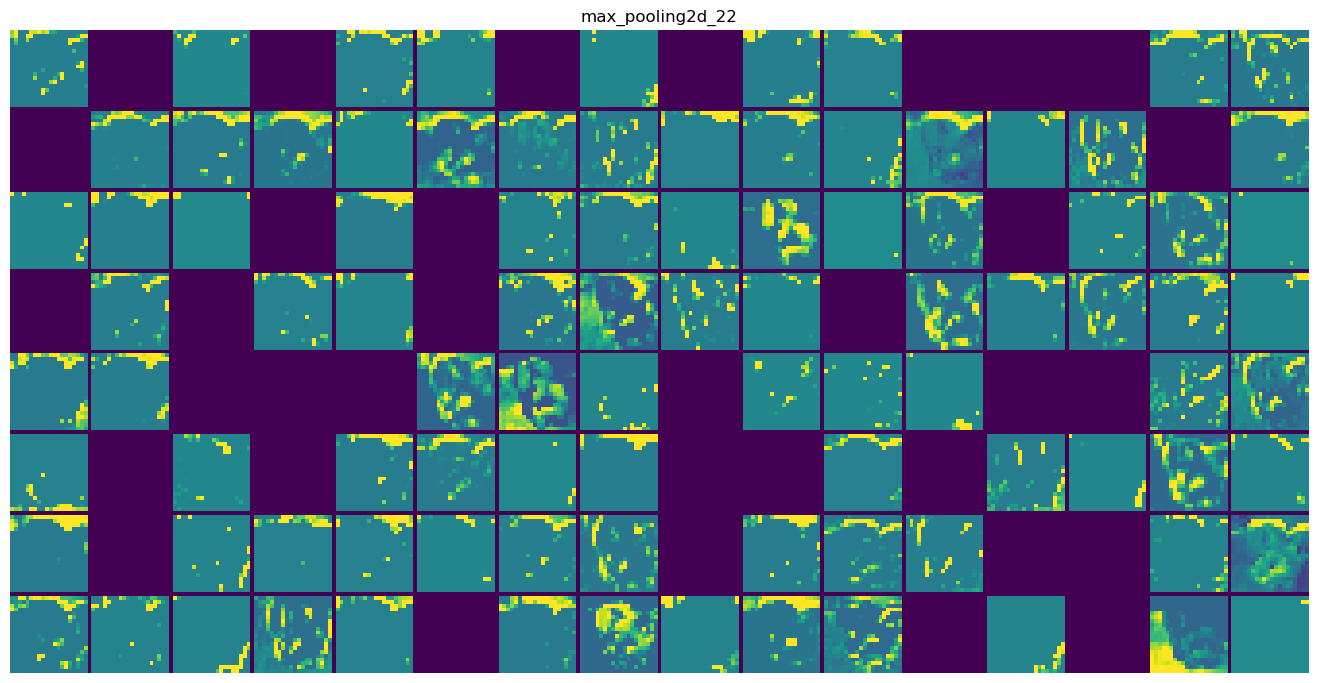

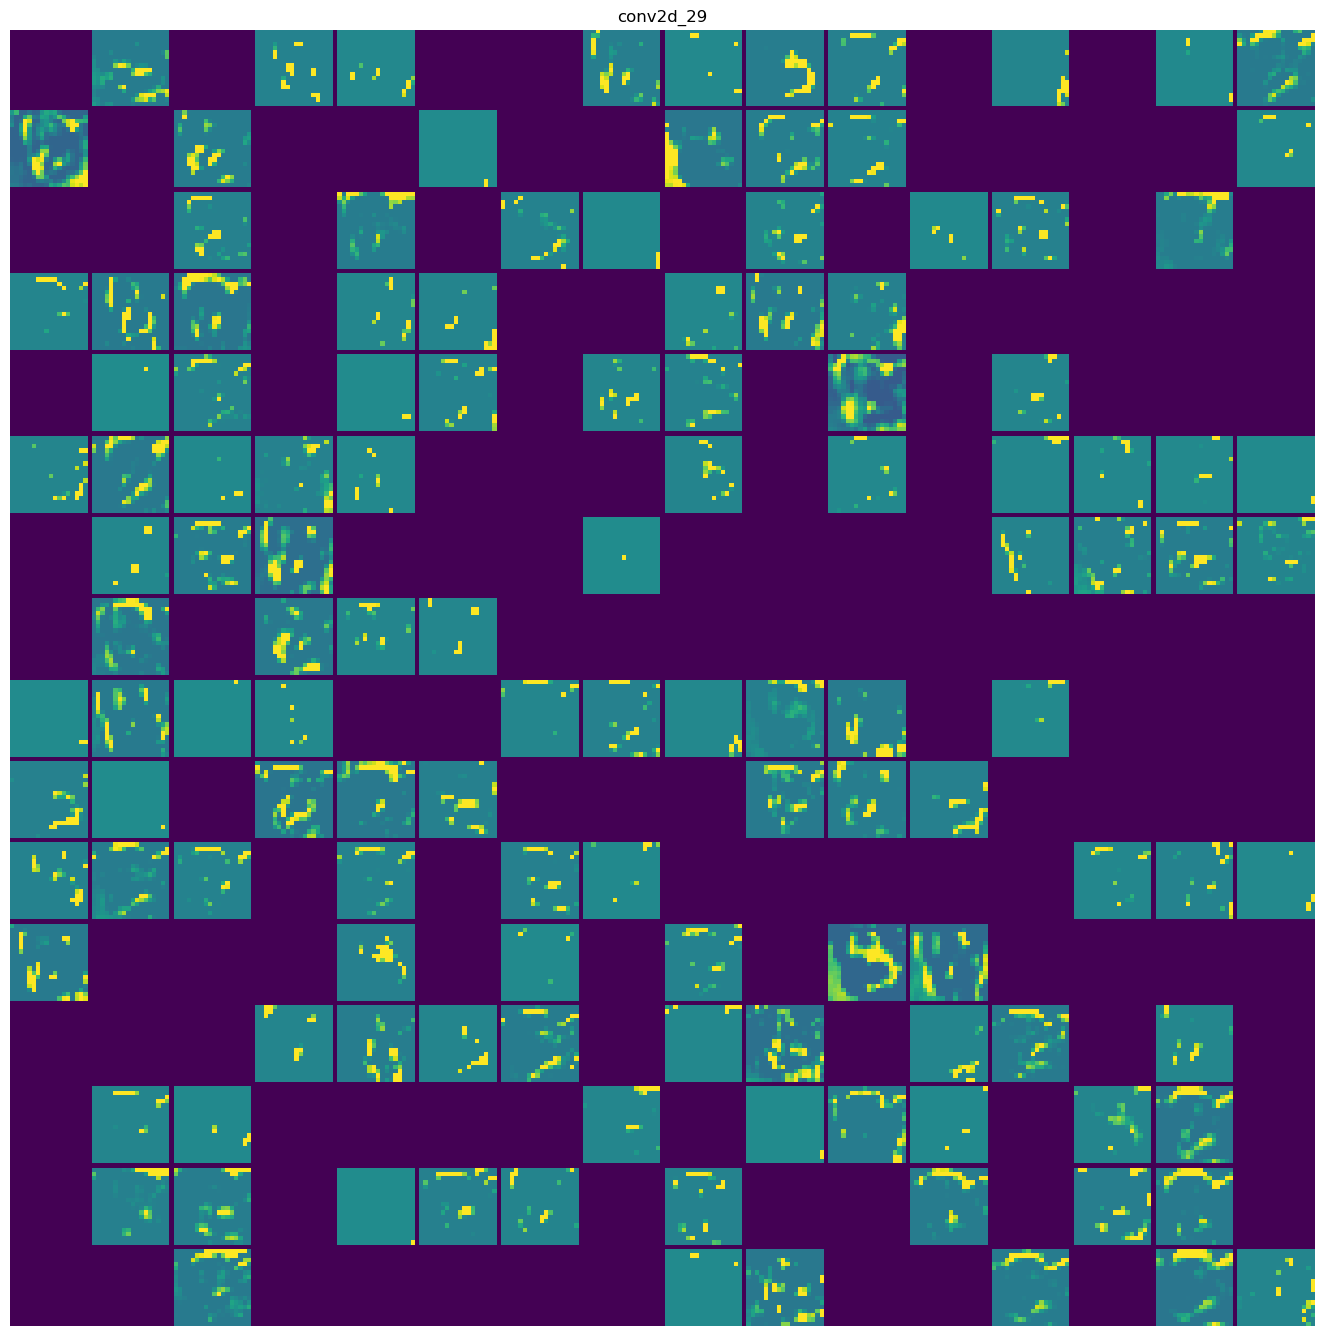

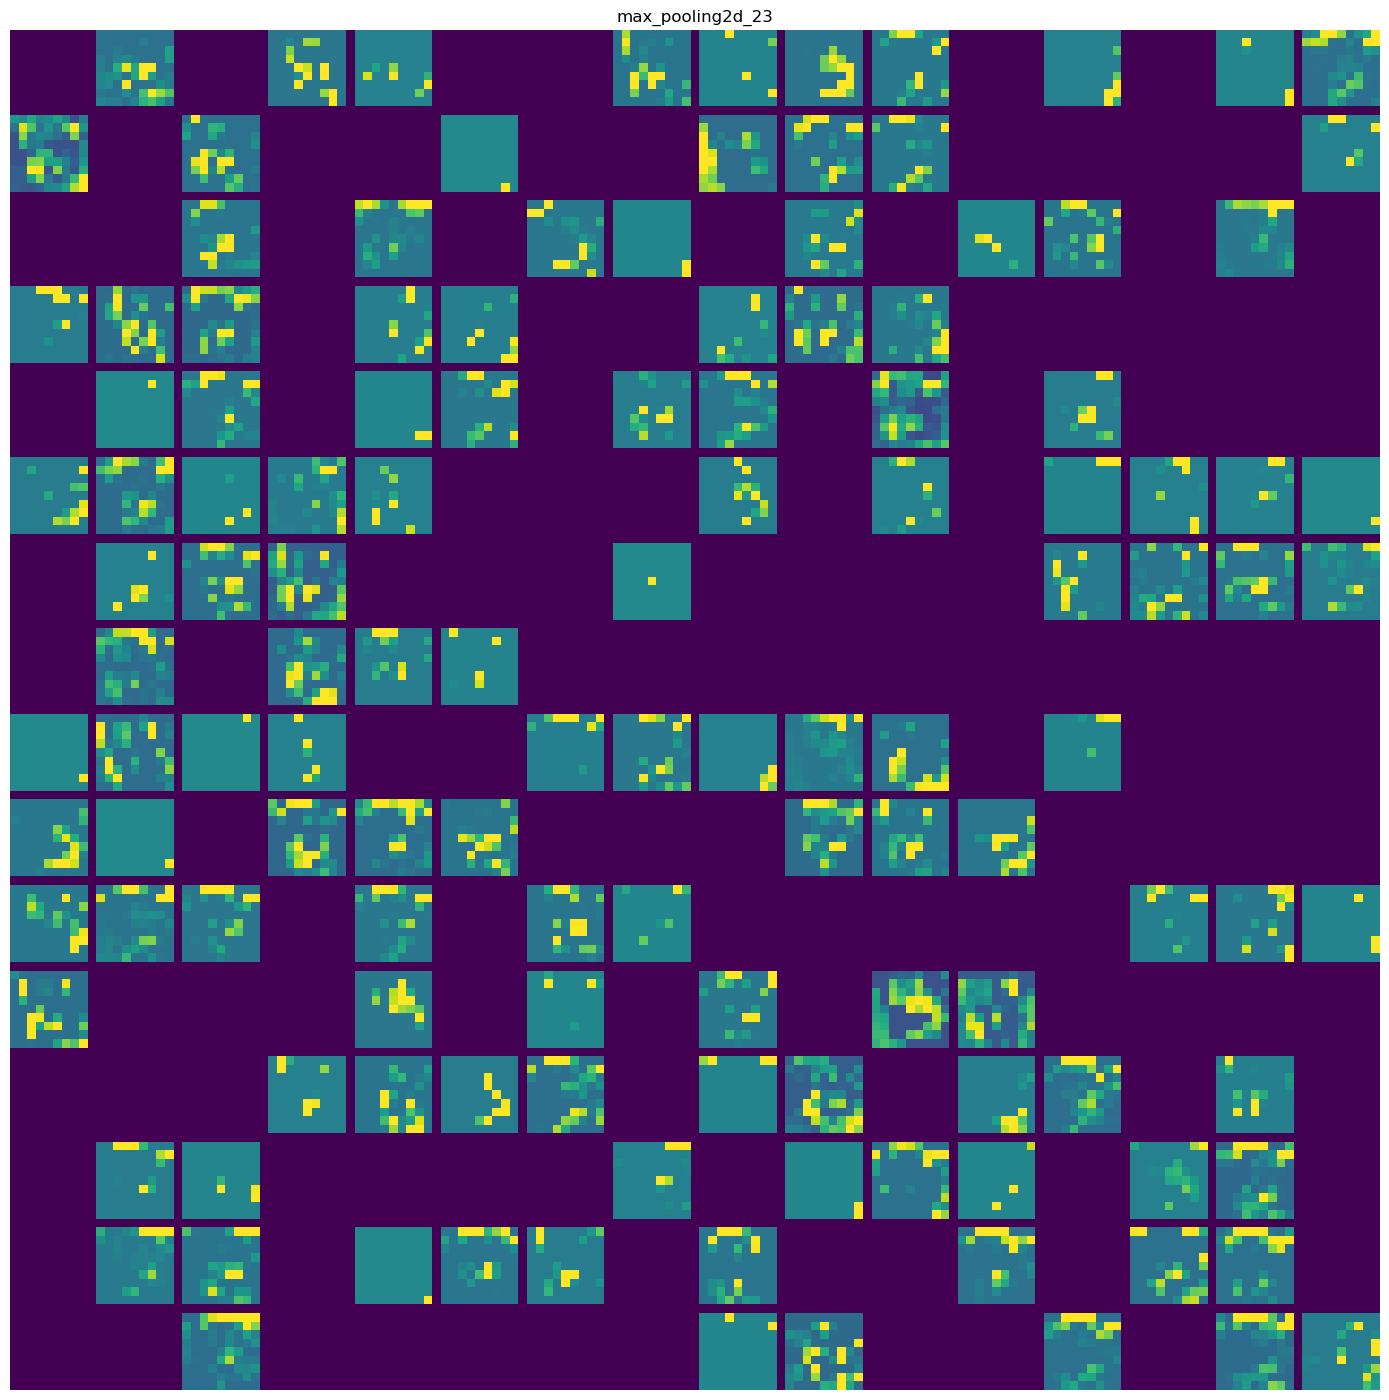

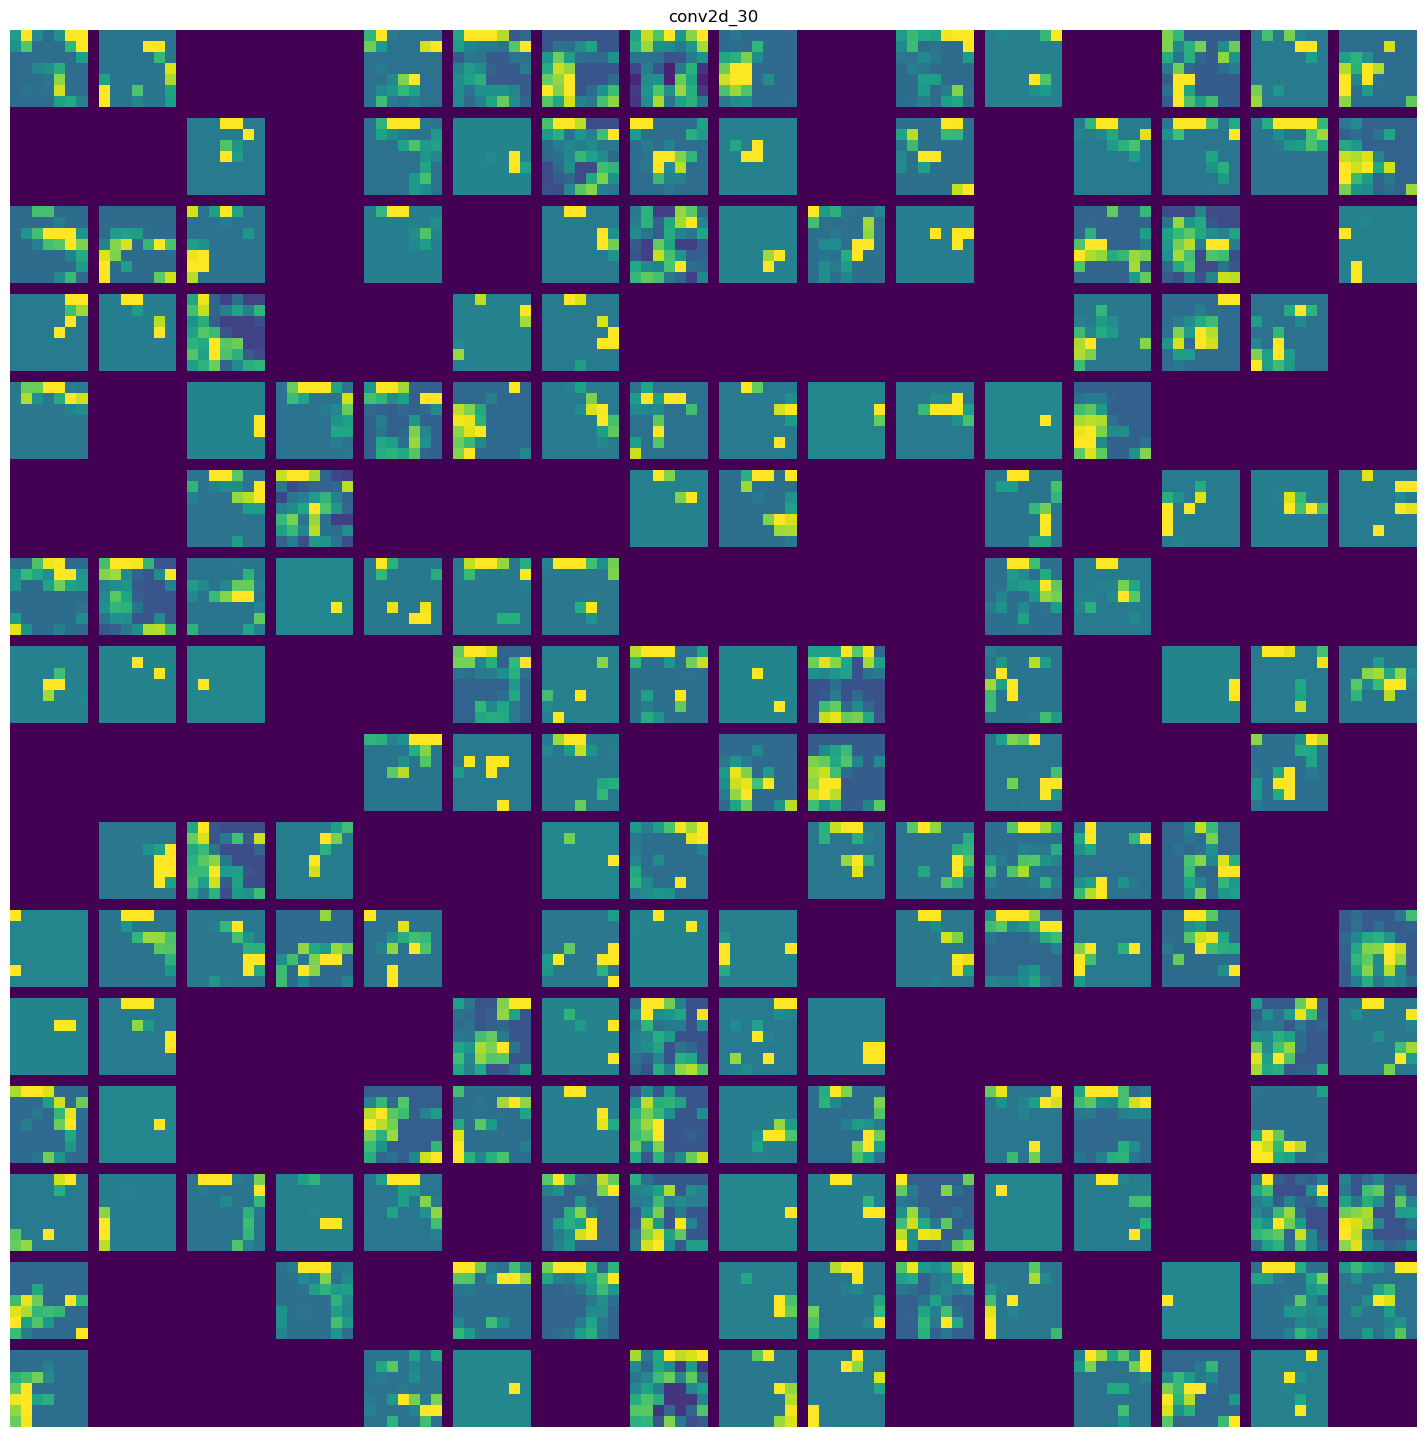

In [35]:
# 将中间激活值的每个通道可视化
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    # 激活值的行装维(1, size, size, n_features)
    n_feature = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_feature // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1, images_per_row * (size + 1) - 1))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[
                col * (size + 1) : (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row
            ] = channel_image
    
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### 可视化滤波器

In [36]:
model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

83683744/83683744 [==============================] - 11s 0us/step
block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d_54
block3_sepconv1
block3_sepconv2
conv2d_55
block4_sepconv1
block4_sepconv2
conv2d_56
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_57
block14_sepconv1
block14_sepconv2


In [54]:
# 创建一个特征提取器模型
layer_name = 'block4_sepconv1'
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)
activation = feature_extractor(keras.applications.xception.preprocess_input(img_tensor))

In [55]:
import tensorflow as tf

# filter_index 滤波器索引
def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    # 避免边界伪影，舍弃了激活边界的两像素
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    # 返回滤波器激活值的均值
    return tf.reduce_mean(filter_activation)

In [56]:
# 创建梯度上升步骤函数
import tensorflow as tf
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        # 明确监控图像张量，因为它不是一个TensorFlow Variable
        tape.watch(image)
        # 计算损失标量，表示当前图像对滤波器的激活程度
        loss = compute_loss(image, filter_index)
    # 计算损失相对于图像的梯度
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    # 将图像沿着能够更强烈激活目标滤波器的方向移动一小步
    image += learning_rate * grads
    return image

In [57]:
# 生成可视化滤波器的函数
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    # 梯度上升的步数
    iterations = 30
    # 单步步长
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=((1, img_width, img_height, 3))
    )
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
        return image[0].numpy()
    
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype('uint8')
    # 中心裁剪，避免边界伪影
    image = image[25:-25, 25:-25, :]
    return image

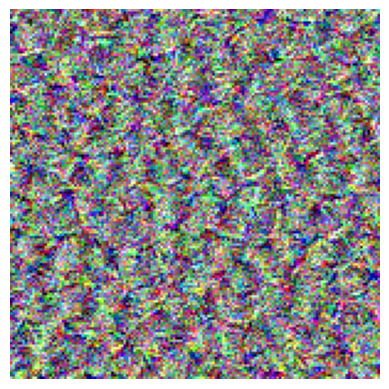

In [58]:
plt.axis('off')
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

In [59]:
# 生成某一层所有filter组成的网络
all_images = []
for filter_index in range(64):
    print(f'Processing filter {filter_index}')
    image = deprocess_image(generate_filter_pattern(filter_index))
    all_images.append(image)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

In [60]:
margin = 5
n = 8
cropped_width = img_width - 25 * 2 
cropped_height = img_height - 25 * 2 
width = n * cropped_width + (n - 1) * margin 
height = n * cropped_height + (n - 1) * margin 
stitched_filters = np.zeros((width, height, 3))

for i in range(n): 
    for j in range(n):         
        image = all_images[i * n + j]         
        row_start = (cropped_width + margin) * i         
        row_end = (cropped_width + margin) * i + cropped_width        
        column_start = (cropped_height + margin) * j         
        column_end = (cropped_height + margin) * j + cropped_height
        stitched_filters[             
            row_start: row_end,             
            column_start: column_end, :] = image 
keras.utils.save_img( f"filters_for_layer_{layer_name}.png", stitched_filters)

### 类激活热力图

In [62]:
model = keras.applications.xception.Xception(weights='imagenet')
img_path = keras.utils.get_file( 
    fname="elephant.jpg",     
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg"
)

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)     
    array = np.expand_dims(array, axis=0)     
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

733657/733657 [==============================] - 1s 1us/step


In [63]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

35363/35363 [==============================] - 0s 9us/step
[('n02504458', 'African_elephant', 0.86996174), ('n01871265', 'tusker', 0.076917894), ('n02504013', 'Indian_elephant', 0.023564849)]


In [64]:
np.argmax(preds[0])

386

In [65]:
# 创建一个模型，返回最后一个卷积输出
last_conv_layer_name = 'block14_sepconv2_act'
classifier_layer_names = [
    "avg_pool",
    "predictions"
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

In [66]:
# 在最后一个卷积输出上再次应用分类器
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

In [67]:
# 计算输入图像的最大预测类别相对于最后一个卷积层激活值的梯度
import tensorflow as tf
with tf.GradientTape() as tape:
    # 计算最后一个卷积层激活值，并让梯度带监控它
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    # 检索与最大预测类别对应的激活通道
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

# 最大预测类别相对于最后一个卷积层输出特征图的梯度
grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [68]:
# 对梯度张量进行汇聚和重要性加权，以得到类激活热力图
# 这是一个向量，其中每个元素是某个通道的平均梯度强度，它量化了每个通道对最大预测类别的重要性。
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy() 
last_conv_layer_output = last_conv_layer_output.numpy()[0]
# 将最后一个卷积层输出的每个通道乘以“该通道的重要性”。
for i in range(pooled_grads.shape[-1]):     
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

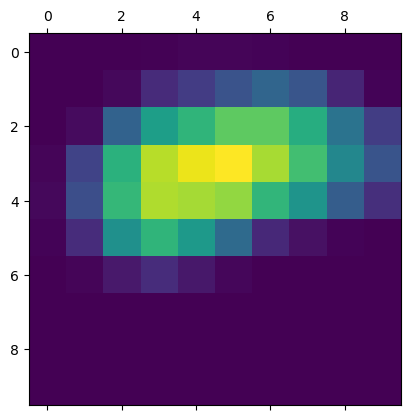

In [69]:
# 热力图后处理
heatmap = np.maximum(heatmap, 0) 
heatmap /= np.max(heatmap) 
plt.matshow(heatmap)

In [70]:
import matplotlib.cm as cm 

img = keras.utils.load_img(img_path) 
img = keras.utils.img_to_array(img) 

heatmap = np.uint8(255 * heatmap) 

jet = cm.get_cmap("jet") 
jet_colors = jet(np.arange(256))[:, :3] 
jet_heatmap = jet_colors[heatmap] 

jet_heatmap = keras.utils.array_to_img(jet_heatmap) 
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap) 

superimposed_img = jet_heatmap * 0.4 + img 
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "elephant_cam.jpg" 
superimposed_img.save(save_path)

C:\Users\morris\AppData\Local\Temp\ipykernel_22216\161035129.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")
